## Graph-Based Image Segmentation using FH Algorithm

Implementation of **Felzenszwalb-Huttenlocher (FH) Algorithm** for image segmentation from scratch.
The implementation uses a **Union-Find (Disjoint Set Union)** data structure (path compression and union by rank).

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.data import *

from collections import defaultdict

np.random.seed(42)

#### Union Find
**Time Complexity**:
- Both operations run in nearly O(1) amortized time with these optimizations
- Specifically: O(α(n)) where α is the inverse Ackermann function (grows extremely slowly)

In [ ]:
class UnionFind:
    def __init__(self, n):
        self.parent = np.arange(n, dtype=np.int32)
        self.rank = np.zeros(n, dtype=np.int32)
        self.size = np.ones(n, dtype=np.int32)
        self.internalDiff = np.zeros(n, dtype=np.float32)


    def find(self, i):
        if self.parent[i] != i:
            self.parent[i] = self.find(self.parent[i])
        return self.parent[i]

    def union(self, i, j, weight):
        rootX = self.find(i)
        rootY = self.find(j)

        if rootX == rootY:
            return False

        if self.rank[rootX] < self.rank[rootY]:
            rootX, rootY = rootY, rootX

        self.parent[rootY] = rootX

        if self.rank[rootX] == self.rank[rootY]:
            self.rank[rootX] += 1

        self.size[rootX] += self.size[rootY]
        self.internalDiff[rootX] = weight

        return True

    def getSize(self, i):
        return self.size[self.find(i)]

    def getInternalDiff(self, i):
        return self.internalDiff[self.find(i)]


### Image Loading and Preprocessing

In [ ]:
def loadSample(name):
    name = name.lower()
    sample = {'astronaut': astronaut(),'coffee': coffee(),'chelsea': chelsea(),'camera': camera(),
        'coins': coins(),'moon': moon(),'page': page(),'text': text(),'rocket': rocket(),'horse': horse()}

    return sample.get(name, astronaut())

def loadFile(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    image = io.imread(path)
    return image


def loadURL(url):
    image = io.imread(url)
    return image


In [ ]:
def convRBG(image):
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]

    return image


def normalize(image):
    if image.dtype == np.uint8:
        image = image.astype(np.float32) / 255.0

    elif image.dtype == np.uint16:
        image = image.astype(np.float32) / 65535.0

    elif image.max() > 1.0:
        image = image.astype(np.float32) / 255.0

    return image.astype(np.float32)

In [ ]:
def loadImage(type='sample', path=None, useLab=False):
    if type == 'sample':
        image = loadSample(path)
    elif type == 'upload':
        image = loadFile(path)
    elif type == 'url':
        image = loadURL(path)

    image = convRBG(image)
    image = normalize(image)
    if useLab:
        image = color.rgb2lab(image)
        print("Converted to LAB color space")

    # print(f"Image shape: {image.shape}")
    return image

### Felzenszwalb Huttenlocher Segmentation Algorithm

The FH algorithm is a graph-based approach that segments an image by treating pixels as nodes and computing edge weights based on color similarity.

In [ ]:
def buildGraph(image, connectivity):
    height, width, channels = image.shape
    edges = []

    if connectivity == 4:
        neigh = [(0, 1), (1, 0)]
    else:
        neigh = [(0, 1), (1, 0), (1, 1), (1, -1)]

    for y in range(height):
        for x in range(width):
            id = y * width + x
            pixelColor = image[y, x]

            for dy, dx in neigh:
                nc, nr = x + dx, y + dy

                if 0 <= nr < height and 0 <= nc < width:
                    adjId = nr * width + nc
                    adjColor = image[nr, nc]

                    weight = np.sqrt(np.sum((pixelColor - adjColor) ** 2))

                    if id < adjId:
                        edges.append((weight, id, adjId))
    return edges

Gaussian smoothing is a technique used to reduce image noise and detail by convolving the image with a Gaussian function.

In [ ]:
def gaussianSmoothing(image, sigma):
    height, width, channels = image.shape
    smoothed = np.zeros(image.shape, dtype=np.float32)

    for c in range(channels):
        smoothed[:, :, c] = filters.gaussian(
            image[:, :, c],
            sigma=sigma,
            mode='reflect'
        )

    return smoothed


In [ ]:
def mergeComp(edges, uf, k):

    def threshold(id):
        internal = uf.getInternalDiff(id)
        size = uf.getSize(id)
        return internal + k / size

    for weight, u, v in edges:
        rootX = uf.find(u)
        rootY = uf.find(v)

        if rootX == rootY:
            continue

        thresholdX = threshold(rootX)
        thresholdY = threshold(rootY)

        if weight <= min(thresholdX, thresholdY):
            uf.union(u, v, weight)


def mergeSmallSegments(edges, uf, minSize):
    neigh = defaultdict(list)
    for weight, u, v in edges:
        rootX = uf.find(u)
        rootY = uf.find(v)

        if rootX != rootY:
            neigh[rootX].append((weight, rootY))
            neigh[rootY].append((weight, rootX))

    totalVert = len(uf.parent)
    for v in range(totalVert):
        root = uf.find(v)
        if (uf.getSize(root) < minSize) and neigh[root]:
            w, n = min(neigh[root], key=lambda x: x[0])
            uf.union(root, n, w)


def segmentationMap(uf, height, width):
    segmentation = np.zeros((height, width), dtype=np.int32)
    label = {}
    curr = 0

    for y in range(height):
        for x in range(width):
            vertex = y * width + x
            root = uf.find(vertex)

            if root not in label:
                label[root] = curr
                curr += 1

            segmentation[y, x] = label[root]

    return segmentation, curr

In [ ]:
def segmentImage(image, k=300, minSize=100, sigma=0.8, connectivity=4):
    height, width, channels = image.shape
    # print("Image", image)
    smoothed = gaussianSmoothing(image, sigma)
    # print("Smoothed", smoothed)

    edges = buildGraph(smoothed, connectivity)
    # print(edges)
    edges.sort(key=lambda x: x[0])

    uf = UnionFind(height * width)
    mergeComp(edges, uf, k)
    mergeSmallSegments(edges, uf, minSize)
    segmentation, totalCnt = segmentationMap(uf, height, width)

    return segmentation, totalCnt

### Visualization

In [ ]:
def visualizeSegmentation(image, segmentation, title="Segmentation Result"):
    N = segmentation.max() + 1
    np.random.seed(42)
    colors = np.random.rand(N, 3)

    seg = colors[segmentation]
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(seg)
    axes[1].set_title(f"{title}\n({N} segments)",
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


def visualizeBoundaries(image, segmentation):
    boundaries = np.zeros_like(segmentation, dtype=bool)
    boundaries[:, :-1] |= segmentation[:, :-1] != segmentation[:, 1:]
    boundaries[:, 1:] |= segmentation[:, :-1] != segmentation[:, 1:]

    boundaries[:-1, :] |= segmentation[:-1, :] != segmentation[1:, :]
    boundaries[1:, :] |= segmentation[:-1, :] != segmentation[1:, :]

    overlay = image.copy()
    overlay[boundaries] = [1, 0, 0]

    plt.figure(figsize=(10, 8))
    plt.imshow(overlay)
    plt.title("Segmentation Boundaries (Red)", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def visualizeOneSegmented(original_image, segmentation, num_show=6):
    N = segmentation.max() + 1
    segment_sizes = [(i, np.sum(segmentation == i)) for i in range(N)]
    segment_sizes.sort(key=lambda x: x[1], reverse=True)
    selected = [seg_id for seg_id, _ in segment_sizes[:num_show]]

    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for idx, seg_id in enumerate(selected[:num_show]):
        mask = segmentation == seg_id

        highlighted = original_image.copy()
        highlighted[~mask] = highlighted[~mask] * 0.3

        axes[idx].imshow(highlighted)
        axes[idx].set_title(f"Segment {seg_id} ({np.sum(mask)} pixels)",
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


def visualizeParamComparison(image, results, grid_shape=(2, 3)):
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
    axes = axes.flatten()

    np.random.seed(42)
    for idx, result in enumerate(results[:rows * cols]):
        seg = result['segmentation']
        num_segs = result['num_segments']
        config = result['config']

        colors = np.random.rand(num_segs, 3)
        colored_seg = colors[seg]

        axes[idx].imshow(colored_seg)

        titles = [config.get('label', f'Config {idx}')]
        if 'k' in config:
            titles.append(f"k={config['k']}")
        if 'min_size' in config:
            titles.append(f"min_size={config['min_size']}")
        if 'sigma' in config:
            titles.append(f"σ={config['sigma']}")
        titles.append(f"{num_segs} segments")

        axes[idx].set_title('\n'.join([titles[0],
                                       ', '.join(titles[1:-1]),
                                       titles[-1]]),
                           fontsize=11, fontweight='bold')
        axes[idx].axis('off')

    for idx in range(len(results), rows * cols):
        axes[idx].axis('off')

    plt.suptitle("Parameter Tuning Comparison", fontsize=16,
                 fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


### Run Segmentation

In [ ]:
# @title
path = 'https://media.istockphoto.com/id/1370510829/vector/map-world-seperate-countries-blue-with-white-outline.jpg?s=612x612&w=0&k=20&c=xM11CVIE6THv9bCcr_xRXb74ZWYQYIcq3YsQB5NSF68='
image = loadImage('url',path , useLab=False)
# image = loadImage('sample', 'astronaut', useLab=False)
segmentation, N = segmentImage(
    image,
    k=30,
    minSize=20,
    sigma=0.5,
    connectivity=8
)

print("Number of segments", N)
# print("Segments", segmentation)

Number of segments 50


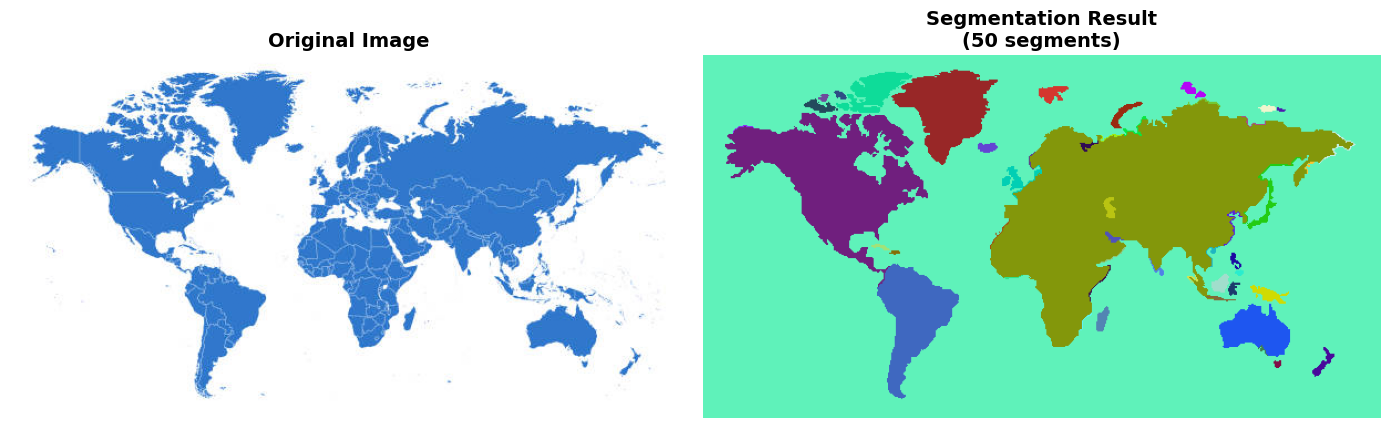

In [ ]:
visualizeSegmentation(image, segmentation, "Segmentation Result")


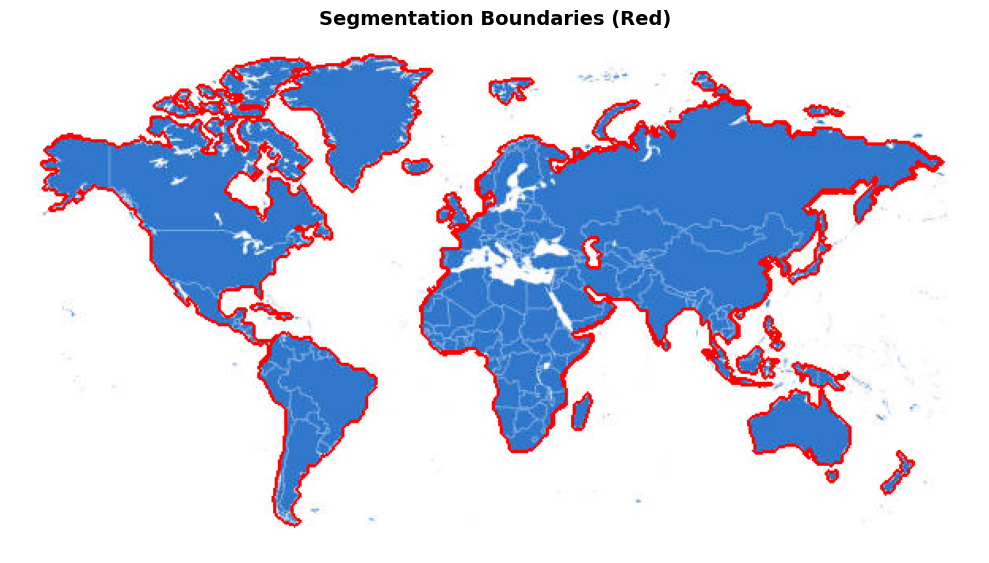

In [ ]:
visualizeBoundaries(image, segmentation)

### Parameter Tuning Experiments

In [ ]:
# @title
config = [
    {'k': 10, 'min_size': 5, 'sigma': 0.5, 'label': 'k=10, min_size=5'},
    {'k': 30, 'min_size': 10, 'sigma': 0.6, 'label': 'k=30, min_size=10'},
    {'k': 50, 'min_size': 15, 'sigma': 0.4, 'label': 'k=50, min_size=15'},
    {'k': 15, 'min_size': 8, 'sigma': 0.4, 'label': 'k=15, min_size=8'},
    {'k': 40, 'min_size': 20, 'sigma': 0.5, 'label': 'k=40, min_size=20'},
    {'k': 20, 'min_size': 6, 'sigma': 0.8, 'label': 'k=20, min_size=6'},
]


results = []
for config in config:

    seg, num_segs = segmentImage(
        image,
        k=config['k'],
        minSize=config['min_size'],
        sigma=config['sigma'],
        connectivity=8
    )

    results.append({
        'segmentation': seg,
        'num_segments': num_segs,
        'config': config
    })

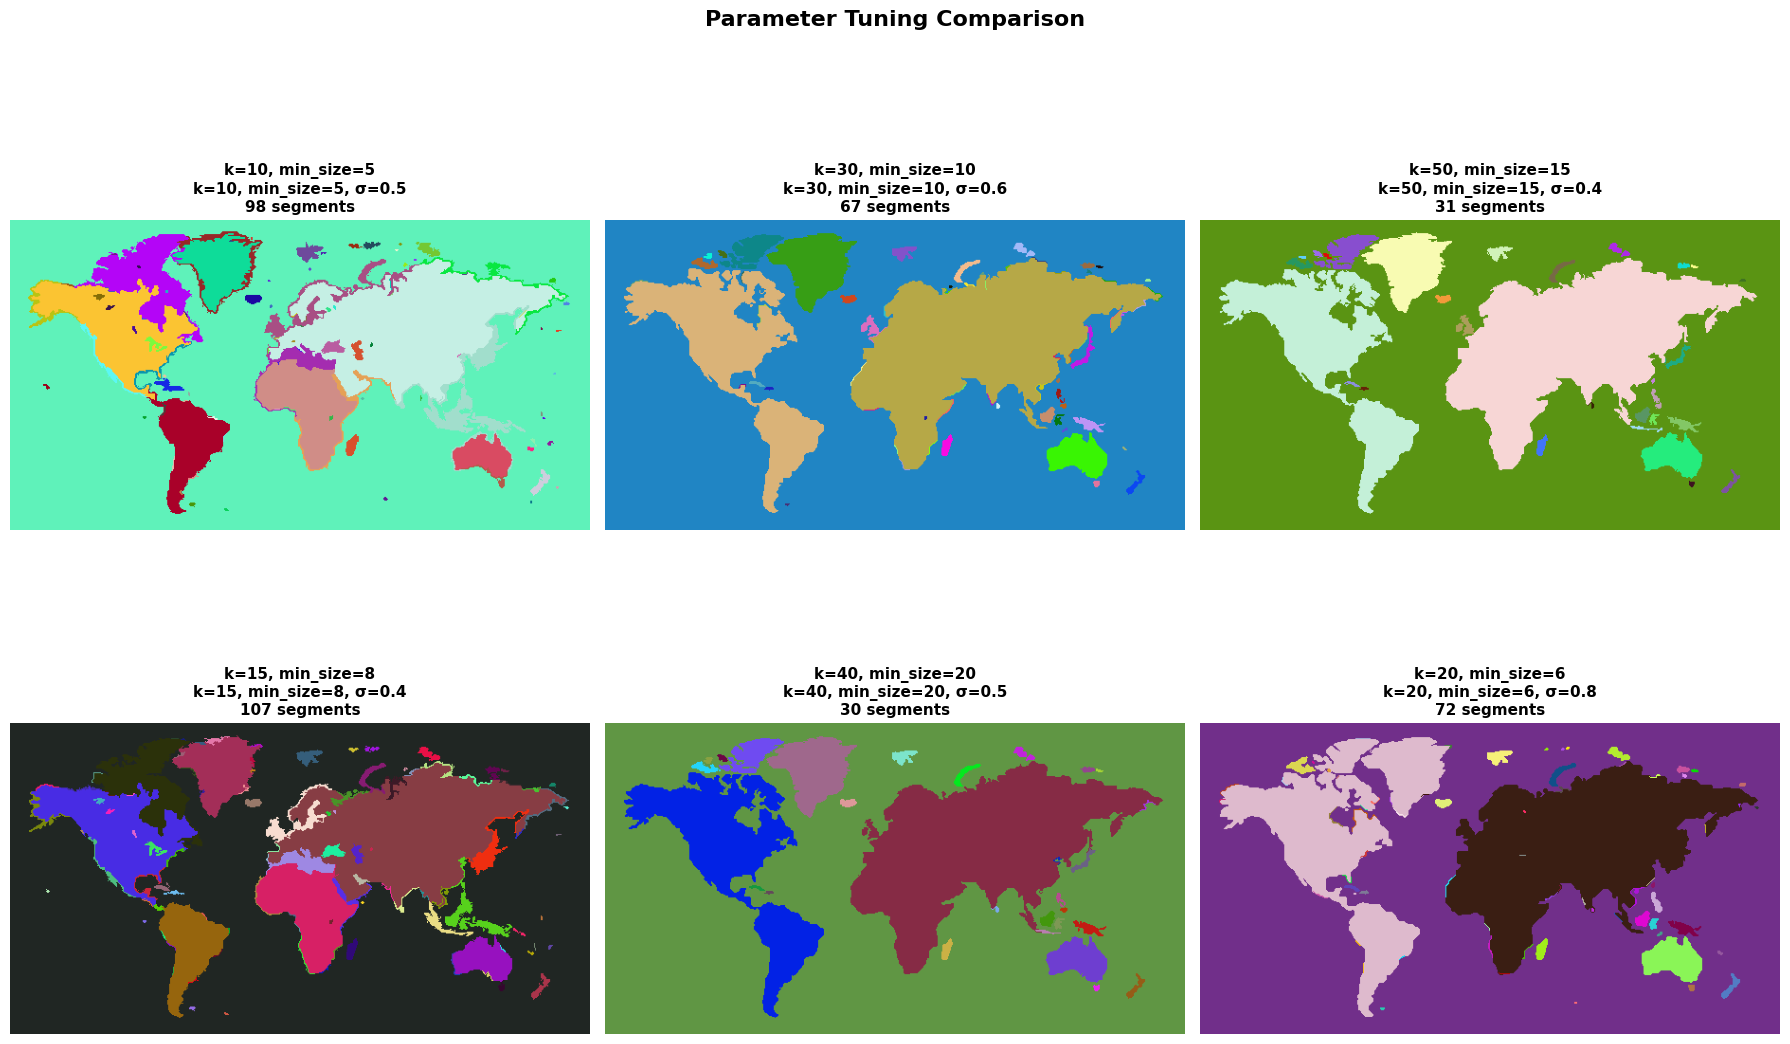

In [ ]:
visualizeParamComparison(image, results)

### Individual Segment Analysis

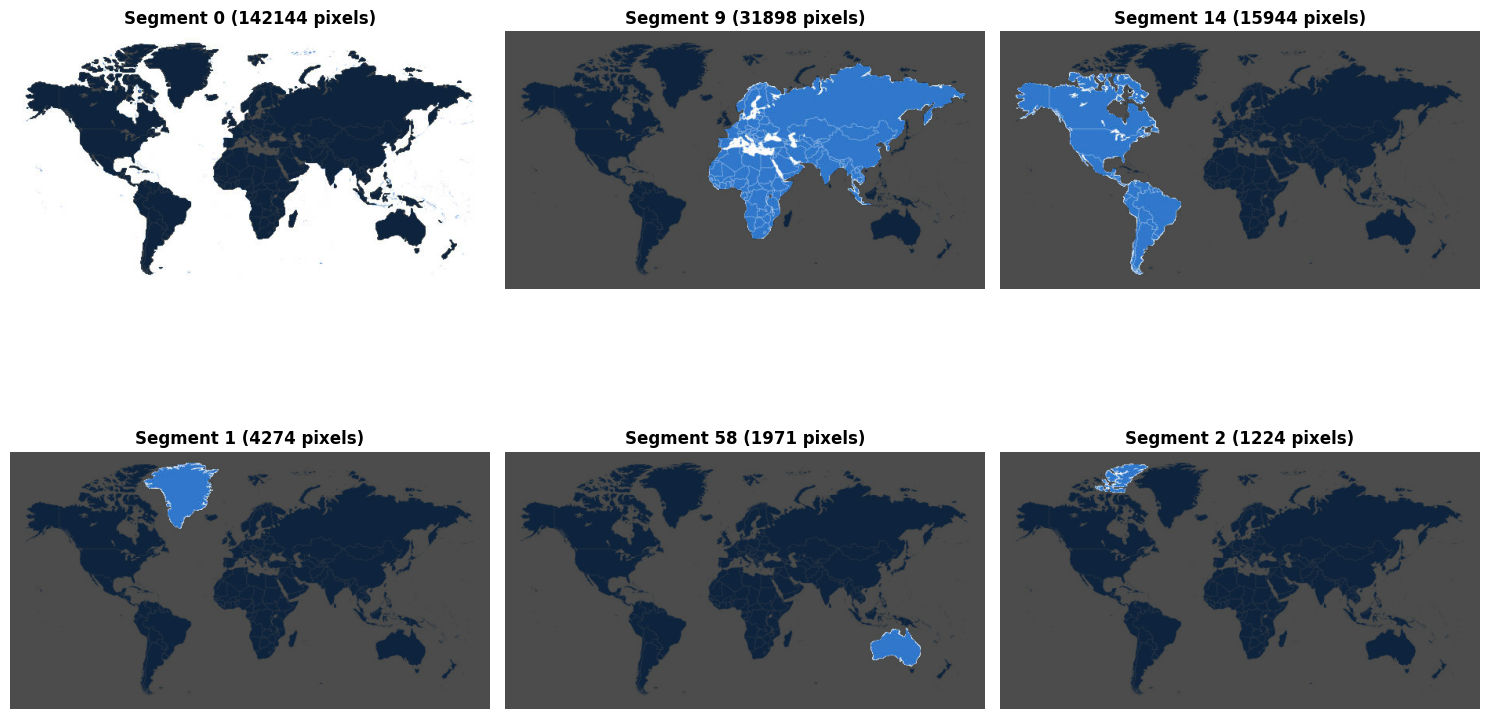

In [ ]:
visualizeOneSegmented(image, results[1]['segmentation'], num_show=6)

### LAB Color
LAB color space is perceptually uniform, meaning Euclidean distances better reflect human color perception.

In [ ]:
# @title

segmentation, M = segmentImage(
    image,
    k=30,
    minSize=20,
    sigma=0.5,
    connectivity=8
)

print("Number of segments in LAB space", M)

Number of segments in LAB space 50


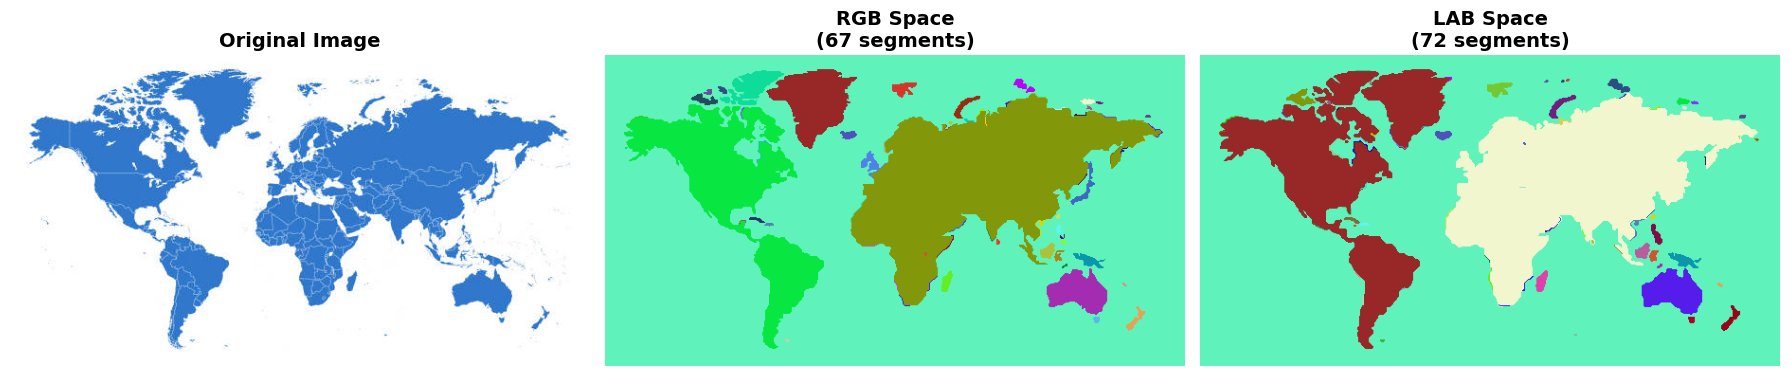

In [ ]:
# @title
if image.shape[-1] == 3 and (image.min() < 0 or image.max() > 1):
    image_display = color.lab2rgb(image)
else:
    image_display = image

num_seg_rgb = results[1]['segmentation'].max() + 1
num_seg_lab = seg.max() + 1

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image_display)
axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
axes[0].axis('off')

np.random.seed(42)
colors_rgb = np.random.rand(num_seg_rgb, 3)
colored_rgb = colors_rgb[results[1]['segmentation']]
axes[1].imshow(colored_rgb)
axes[1].set_title(f"RGB Space\n({num_seg_rgb} segments)",
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

np.random.seed(42)
colors_lab = np.random.rand(num_seg_lab, 3)
colored_lab = colors_lab[seg]
axes[2].imshow(colored_lab)
axes[2].set_title(f"LAB Space\n({num_seg_lab} segments)",
                  fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()